In [3]:
# module1 Libraries
import os
import cv2
import json
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K

from tensorflow.keras.losses import Loss
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import (Input, Attention, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dense, GlobalAvgPool2D,
                                     GRU, Multiply, MaxPooling2D, BatchNormalization, Lambda,Bidirectional,ReLU, Add, 
                                     Dropout, LSTM, MultiHeadAttention, Reshape,Flatten,LayerNormalization, 
                                     GlobalMaxPooling2D,Concatenate)
from skimage.segmentation import mark_boundaries
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, roc_curve, precision_recall_curve, classification_report
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pywt
import shap
from lime import lime_image
from tf_explain.core.grad_cam import GradCAM


In [ ]:
root_dir = r'Data set example'
train_dir = os.path.join(root_dir, "train")  # Your training data directory
val_dir = os.path.join(root_dir, "val")  # Your validation data directory
test_dir = os.path.join(root_dir, "test")  # Your test data directory

# Center crop preprocessing
def preprocess_image(image):
    h, w, _ = image.shape
    center_x, center_y = w // 2, h // 2
    crop_size = min(center_x, center_y)
    cropped_image = image[
        center_y - crop_size:center_y + crop_size,
        center_x - crop_size:center_x + crop_size
    ]
    resized_image = cv2.resize(cropped_image, (224, 224))
    normalized_image = resized_image / 255.0  
    return normalized_image
# Training data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.9, 1.3],
    channel_shift_range=50.0,
    shear_range=0.4,
    rotation_range=240,
    preprocessing_function=preprocess_image,  # Apply center crop and normalization
)

# Validation and test data generators (no augmentation)
test_datagen = ImageDataGenerator(rescale=1.0/255)  # Only rescaling for validation and test data

# Training set generator (load from train_dir)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Shuffle training data
)

# Validation set generator (load from val_dir, no augmentation)
validation_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Validation data should not be shuffled
)

# Test set generator (load from test_dir, no augmentation)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Test data should not be shuffled
)

print("Class indices mapping:", train_generator.class_indices)

Found 5 images belonging to 5 classes.
Found 0 images belonging to 0 classes.
Found 5 images belonging to 5 classes.
Class indices mapping: {'0-No DR': 0, '1-Mild': 1, '2-Moderate': 2, '3-Severe': 3, '4-Proliferative DR': 4}


Displaying preprocessed training images:


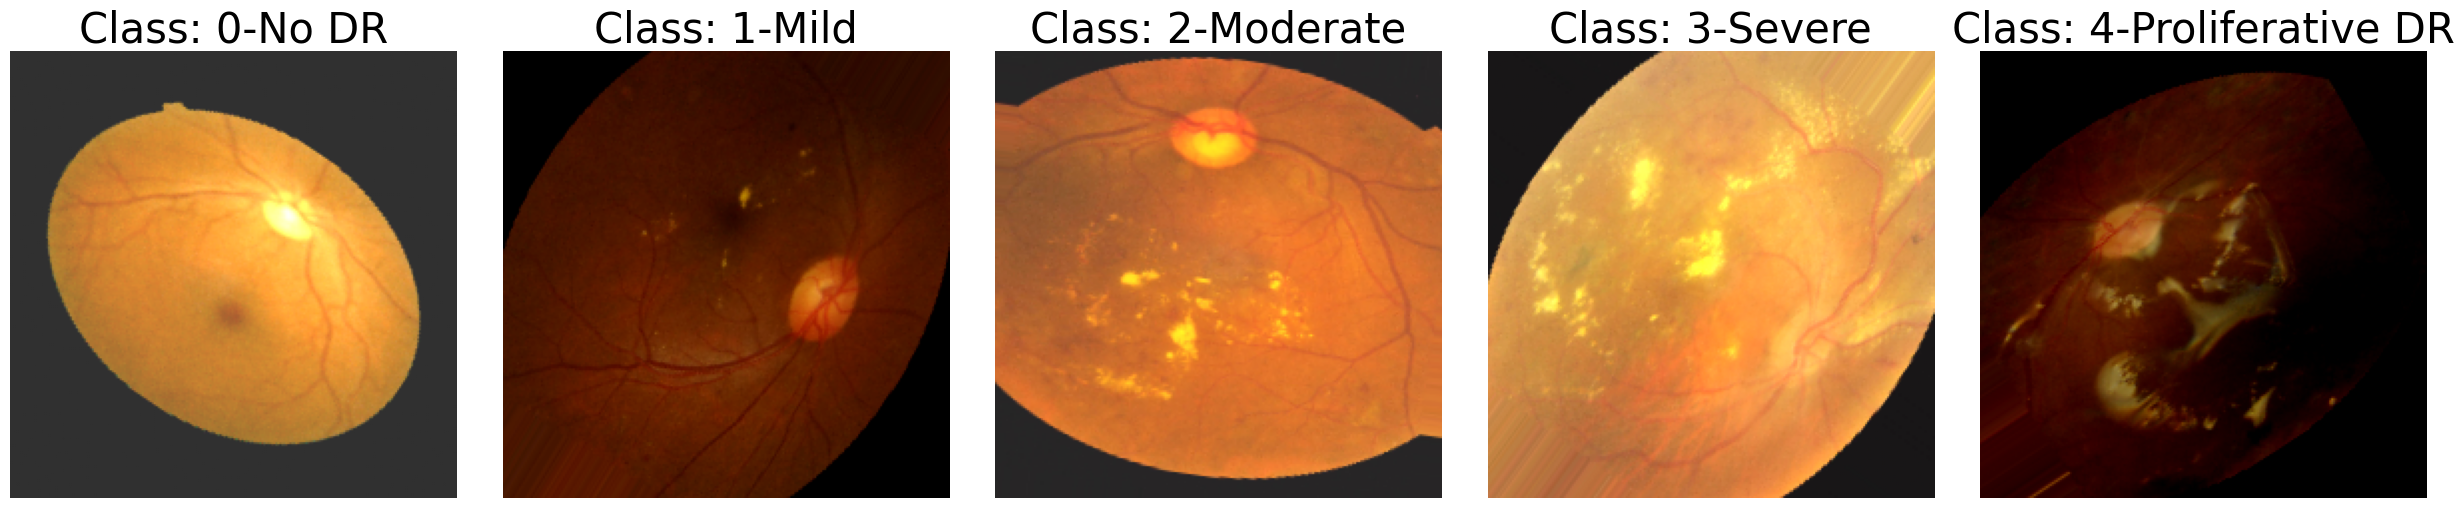


Displaying preprocessed validation images:


<Figure size 2500x2500 with 0 Axes>


Displaying preprocessed test images:


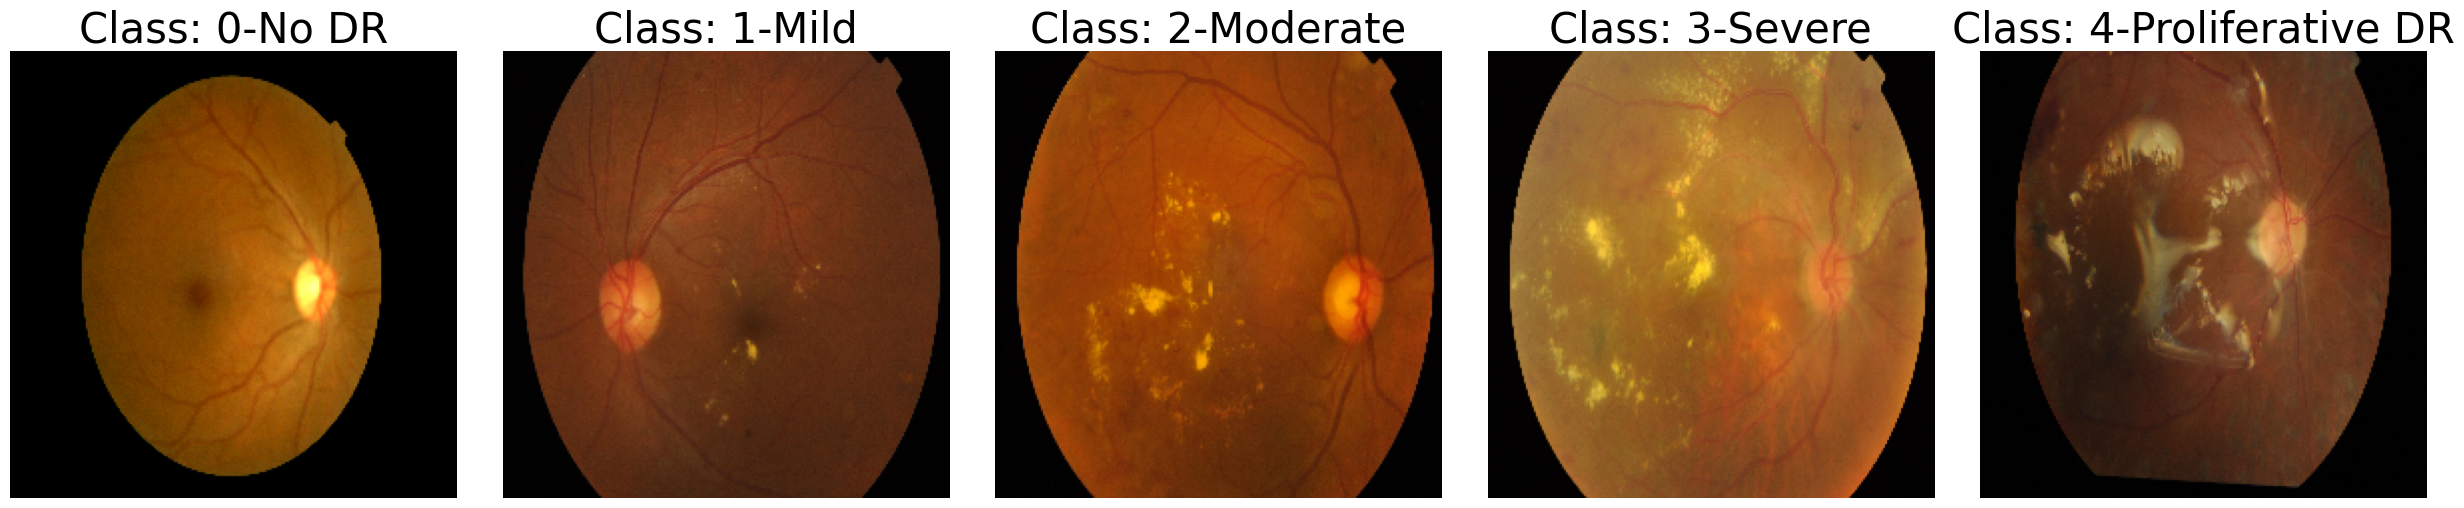

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display images
def display_images(generator, num_images=8):
    # Get a batch of images
    images, labels = next(generator)
    
    # Get class names from the generator
    class_names = list(generator.class_indices.keys())
    
    # Create a figure
    plt.figure(figsize=(25, 25))
    plt.rcParams.update({'font.size': 25})
    # Display images
    for i in range(min(num_images, len(images))):
        plt.subplot(5, 5, i+1)  # Create a 4x4 grid for displaying images
        plt.imshow(images[i])
        plt.title(f"Class: {class_names[np.argmax(labels[i])]}")  # Get the class name from the labels
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Display preprocessed training images
print("Displaying preprocessed training images:")
display_images(train_generator, num_images=8)

# Display preprocessed validation images
print("\nDisplaying preprocessed validation images:")
display_images(validation_generator, num_images=8)

# Display preprocessed test images
print("\nDisplaying preprocessed test images:")
display_images(test_generator, num_images=8)